# Classifier code for training the datasets

## Generate Datasets

In [32]:
import numpy as np
import pickle
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB#
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
import time
import sys
#df = pd.read_csv('/its/home/drs25/Documents/GitHub/TactileSensor/Code/Data collection/robot/movementLeftFoot.csv')
#df=(df-df.std())/(df.mean())
path="/its/home/drs25/GonkRobot/Data/raw/"
if sys.platform.startswith('win'):
    path="C:/Users/dexte/Documents/GitHub/TactileSensor/Code/Data collection/robot/New_feet/raw/"
df = pd.read_csv(path+'carpet_d1.1_raw_L.csv')
#df=(df-df.std())/(df.mean())

print(df.keys())

torch.cuda.empty_cache() 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.version.cuda)
print("GPU:",torch.cuda.is_available())
def get_foot_image(processed): #get the image of an array
    grid=np.zeros((3,5))
    grid[2][4]=processed[0]
    grid[2][3]=processed[1]
    grid[2][2]=processed[2]
    grid[2][1]=processed[3]
    grid[2][0]=processed[4]

    grid[1][3]=processed[8]
    grid[1][2]=processed[9]
    grid[1][1]=processed[6]
    grid[1][0]=processed[5]

    grid[0][4]=processed[10]
    grid[0][3]=processed[11]
    grid[0][2]=processed[12]
    grid[0][1]=processed[13]
    grid[0][0]=processed[14]
    grid=(grid-np.min(grid))/(np.max(grid)-np.min(grid))
    return grid

def genDataSet(var,texture=False,days=True,left=True,right=True):
    if right and not left:
        X,y=sort_data("wood_d1_raw_R.csv",var)
    elif left and not right:
        X,y=sort_data("wood_d1_raw_L.csv",var)
    if right:
        X1,y1=sort_data("wood_d2.1_raw_R.csv",var)
        X=np.concatenate((X,X1),axis=0)
        y=np.concatenate((y,y1),axis=0)
        X1,y1=sort_data("wood_d2.3_raw_R.csv",var)
        X=np.concatenate((X,X1),axis=0)
        y=np.concatenate((y,y1),axis=0)
        X1,y1=sort_data("wood_d2_raw_R.csv",var)
        X=np.concatenate((X,X1),axis=0)
        y=np.concatenate((y,y1),axis=0)
    if left:
        if not right:
            X1,y1=sort_data("wood_d1_raw_L.csv",var)
            X=np.concatenate((X,X1),axis=0)
            y=np.concatenate((y,y1),axis=0)
        X1,y1=sort_data("wood_d2.1_raw_L.csv",var)
        X=np.concatenate((X,X1),axis=0)
        y=np.concatenate((y,y1),axis=0)
    if texture:
        if left:
            X1,y1=sort_data("carpet_d1.1_raw_L.csv",var)
            X=np.concatenate((X,X1),axis=0)
            y=np.concatenate((y,y1),axis=0)
            X1,y1=sort_data("carpet_d1_raw_L.csv",var)
            X=np.concatenate((X,X1),axis=0)
            y=np.concatenate((y,y1),axis=0)
            X1,y1=sort_data("concrete_d2_raw_L.csv",var)
            X=np.concatenate((X,X1),axis=0)
            y=np.concatenate((y,y1),axis=0)
            X1,y1=sort_data("concrete_d2.1_raw_L.csv",var)
            X=np.concatenate((X,X1),axis=0)
            y=np.concatenate((y,y1),axis=0)
            X1,y1=sort_data("RoughRock_d3_raw_L.csv",var)
            X=np.concatenate((X,X1),axis=0)
            y=np.concatenate((y,y1),axis=0)
            X1,y1=sort_data("Smooth_d4_raw_L.csv",var)
            X=np.concatenate((X,X1),axis=0)
            y=np.concatenate((y,y1),axis=0)
        if right:
            X1,y1=sort_data("carpet_d1_raw_R.csv",var)
            X=np.concatenate((X,X1),axis=0)
            y=np.concatenate((y,y1),axis=0)
            X1,y1=sort_data("carpet_d1.1_raw_R.csv",var)
            X=np.concatenate((X,X1),axis=0)
            y=np.concatenate((y,y1),axis=0)
            X1,y1=sort_data("concrete_d2_raw_R.csv",var)
            X=np.concatenate((X,X1),axis=0)
            y=np.concatenate((y,y1),axis=0)
            X1,y1=sort_data("concrete_d2.1_raw_R.csv",var)
            X=np.concatenate((X,X1),axis=0)
            y=np.concatenate((y,y1),axis=0)
            X1,y1=sort_data("RoughRock_d3_raw_R.csv",var)
            X=np.concatenate((X,X1),axis=0)
            y=np.concatenate((y,y1),axis=0)
            X1,y1=sort_data("Smooth_d4_raw_R.csv",var)
            X=np.concatenate((X,X1),axis=0)
            y=np.concatenate((y,y1),axis=0)
        if days:
            if left:
                X1,y1=sort_data("Carpet_d4_raw_L.csv",var)
                X=np.concatenate((X,X1),axis=0)
                y=np.concatenate((y,y1),axis=0)
            if right:
                X1,y1=sort_data("Carpet_d4_raw_R.csv",var)
                X=np.concatenate((X,X1),axis=0)
                y=np.concatenate((y,y1),axis=0)
    return X,y

def sort_data(name,vibration=True,dir="all"):
    df = pd.read_csv(path+name)
    df=pd.DataFrame(df).fillna(0)
    if vibration:
        ar=[]
        for key in list(df.keys()):
            if key not in ["time_step","x","y","z"]:
                ar.append(df[key])
        x=np.array(ar)
    else: #return without vibration data
        ar=[]
        for key in list(df.keys()):
            if key not in ["time_step","x","y","z","s_1_7","s_2_7"]:
                ar.append(df[key])
        x=np.array(ar)
    if dir=="left":
        ar=[]
        for key in list(df.keys()):
            if key not in ["time_step","x","y","z"] and "s_1" in key:
                ar.append(df[key])
        x=np.array(ar)
    elif dir=="right":
        ar=[]
        for key in list(df.keys()):
            if key not in ["x","y","z"] and "s_2" in key:
                ar.append(df[key])
        x=np.array(ar)
    x=x.T #transpose to have layers
    y=np.array([df['x'],df['y'],df['z']])
    y=y.T
    nan_indices = np.where(np.isnan(y))
    y[nan_indices]=0
    print("X data:",x.shape,"/ny data:",y.shape)
    return x,y

def getReductionMatrix(filename):
    x,y=sort_data(filename,vibration=True,dir="all") #loop through file name
    reduction = np.average(x,axis=0)
    return reduction

def gen_temporal_data(X_,y_,T):
    X=X_.copy()
    temp_x=np.zeros((X.shape[0]-T,X.shape[1]*T))
    temp_y=np.zeros((X.shape[0]-T,y_.shape[1]))
    for j in range(len(y_)-T): #loop through classes
        ar=[X[j+k] for k in range(T)]
        temp_x[j]=np.concatenate(ar,axis=0)
        temp_y[j]=y_[j]
    x=temp_x
    y=temp_y
    return x, y

def gen_temporal_data_2(X_,y_,T):
    X=X_.copy()
    temp_x=np.zeros((X.shape[0]-T,T,X.shape[1]))
    temp_y=np.zeros((X.shape[0]-T,y_.shape[1]))
    for j in range(len(y_)-T): #loop through classes
        ar=[X[j+k] for k in range(T)]
        temp_x[j]=np.array(ar)
        temp_y[j]=y_[j]
    x=temp_x
    y=temp_y
    return x, y


def reduction_matrix(x_standard):
    return np.average(x_standard,axis=0)


class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(SimpleNN, self).__init__()

        # Create a list to store the layers of the neural network
        layers = []

        # Add the input layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())  # You can use other activation functions as well
        #print(layers[0].weight.dtype)
        # Add the hidden layers
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))
            layers.append(nn.ReLU())  # You can use other activation functions as well

        # Add the output layer
        layers.append(nn.Linear(hidden_sizes[-1], output_size))

        # Combine all layers into a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # Define the forward pass of the network
        return self.model(x)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagation
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

def train(X_train,Y_train,X_test,Y_test,batch_size=64,num_epochs = 100,learning_rate = 0.01,acc_check=0):
    # Split your dataset into training and validation sets
    # train_data, val_data = ...
    lstm_model=LSTMModel(X_train.shape[2],500,2,Y_train.shape[1]).to(device)
    # Create data loaders for training and validation

    # Initialize the optimizer
    optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    history_train=[]
    history_test=[]
    # Training loop
    for epoch in range(num_epochs):
        lstm_model.train()
        total_loss=0
        for i in range(0,len(X_train)-batch_size,batch_size):
            optimizer.zero_grad()
            # Forward pass
            outputs = lstm_model(X_train[i:i+batch_size])

            # Calculate the loss
            loss = criterion(outputs, Y_train[i:i+batch_size])

            # Backpropagation
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        history_train.append(total_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")
        if epoch%100==0:
            # Validation
            lstm_model.eval()
            with torch.no_grad():
                total_val_loss = 0

                outputs = lstm_model(X_test)
                val_loss = criterion(outputs, Y_test)
                total_val_loss = val_loss.item()

                print(f"Validation Loss: {total_val_loss:.4f}")
                history_test.append(total_val_loss)
            if acc_check:
                predictions=lstm_model(X_test)
                ind=torch.argmax(predictions,axis=1).cpu().detach().numpy()
                pred=np.zeros_like(predictions.cpu().detach().numpy())
                for i in range(len(pred)):
                    pred[i][ind[i]]=1
                accuracy = accuracy_score(Y_test.cpu().detach().numpy(), pred)
                print("Acc:",accuracy*100,"%")
    # Save the trained model
    #torch.save(lstm_model.state_dict(), "lstm_model.pth")
    if acc_check:
        predictions=lstm_model(X_test)
        ind=torch.argmax(predictions,axis=1).cpu().detach().numpy()
        pred=np.zeros_like(predictions.cpu().detach().numpy())
        for i in range(len(pred)):
            pred[i][ind[i]]=1
        accuracy = accuracy_score(Y_test.cpu().detach().numpy(), pred)
        print("Acc:",accuracy*100,"%")
    return history_train, history_test, lstm_model

Index(['time_step', 'x', 'y', 'z', 's_1_0', 's_1_1', 's_1_2', 's_1_3', 's_1_4',
       's_1_5', 's_1_6', 's_1_7', 's_1_8', 's_1_9', 's_1_10', 's_1_11',
       's_1_12', 's_1_13', 's_1_14', 's_1_15', 's_2_0', 's_2_1', 's_2_2',
       's_2_3', 's_2_4', 's_2_5', 's_2_6', 's_2_7', 's_2_8', 's_2_9', 's_2_10',
       's_2_11', 's_2_12', 's_2_13', 's_2_14', 's_2_15'],
      dtype='object')
11.8
GPU: True


## Regress orientation

This section takes in a temporal window of tactile data and classifies which texture it is belonging to

In [33]:
var=1
X,y=sort_data("wood_d1_raw_R.csv",var)
X1,y1=sort_data("wood_d1_raw_L.csv",var)
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("wood_d2.1_raw_L.csv",var)
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("wood_d2.1_raw_R.csv",var)
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("wood_d2.3_raw_R.csv",var)
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("wood_d2_raw_R.csv",var)
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)

wood_X=X.copy()
wood_y=y.copy()

X,y=sort_data("carpet_d1.1_raw_L.csv",var)
X1,y1=sort_data("carpet_d1.1_raw_R.csv",var)
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("carpet_d1_raw_L.csv",var)
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("carpet_d1_raw_R.csv",var)
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)

carpet_x=X.copy()
carpet_y=y.copy()

X,y=sort_data("concrete_d2_raw_L.csv",var)
X1,y1=sort_data("concrete_d2_raw_R.csv",var)
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("concrete_d2.1_raw_L.csv",var)
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("concrete_d2.1_raw_R.csv",var)
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)

concrete_X=X.copy()
concrete_y=y.copy()

X,y=sort_data("Smooth_d4_raw_L.csv",var)
X1,y1=sort_data("Smooth_d4_raw_R.csv",var)
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)

smooth_X=X.copy()
smooth_y=y.copy()
print(concrete_X.shape,carpet_x.shape,wood_X.shape,smooth_X.shape)
print(concrete_y.shape,carpet_y.shape,wood_y.shape,smooth_y.shape)

X data: (3600, 32) /ny data: (3600, 3)
X data: (4950, 32) /ny data: (4950, 3)
X data: (4950, 32) /ny data: (4950, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (4950, 32) /ny data: (4950, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (4950, 32) /ny data: (4950, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (4950, 32) /ny data: (4950, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (4950, 32) /ny data: (4950, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (4950, 32) /ny data: (4950, 3)
X data: (3600, 32) /ny data: (3600, 3)
(17100, 32) (17100, 32) (24300, 32) (8550, 32)
(17100, 3) (17100, 3) (24300, 3) (8550, 3)


### Random forrest 

In [34]:
def runRF(t=80):
    X=np.concatenate([concrete_X,carpet_x,wood_X,smooth_X])
    y=np.concatenate([concrete_y,carpet_y,wood_y,smooth_y])

    X,y=gen_temporal_data(X,y,t)
    print(X.shape,y.shape)
    X=(X-np.mean(X))/(np.std(X))

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_classifier = RandomForestRegressor(n_estimators=25)

    # Train the classifier on the training data
    rf_classifier.fit(X_train, y_train)

    # Make predictions on the test data
    predictions_train = rf_classifier.predict(X_train)
    predictions_test = rf_classifier.predict(X_test)

    mse1 = mean_squared_error(y_train, predictions_train)
    mse2 = mean_squared_error(y_test, predictions_test)
    print("Train:",mse1,"Test:",mse2)
    return mse1,mse2

### Ridge

In [35]:
def runRidge(t=80):
    X=np.concatenate([concrete_X,carpet_x,wood_X,smooth_X])
    y=np.concatenate([concrete_y,carpet_y,wood_y,smooth_y])
    X,y=gen_temporal_data(X,y,t)
    X=(X-np.mean(X))/(np.std(X))
    print(X.shape,y.shape)
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    ridge = Ridge(alpha=1)

    # Train the classifier on the training data
    ridge.fit(X_train, y_train)

    # Make predictions on the test data
    predictions_train = ridge.predict(X_train)
    predictions_test = ridge.predict(X_test)

    mse1 = mean_squared_error(y_train, predictions_train)
    mse2 = mean_squared_error(y_test, predictions_test)
    print("Train:",mse1,"Test:",mse2)
    return mse1,mse2
#runRidge()

### FNN

In [46]:
def runFNN(t=80):
    X=np.concatenate([concrete_X,carpet_x,wood_X,smooth_X])
    y=np.concatenate([concrete_y,carpet_y,wood_y,smooth_y])
    X,y=gen_temporal_data(X,y,t)
    X=(X-np.mean(X))/(np.std(X))
    y=(y-np.mean(y))/(np.std(y))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train=torch.tensor(X_train,dtype=torch.float32).to(device)
    y_train=torch.tensor(y_train,dtype=torch.float32).to(device)
    model = SimpleNN(len(X_train[0]), [1000,50], 3).to(device)

    # Define the loss function and the optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    num_epochs=10000

    for epoch in range(num_epochs):
        total_loss = 0.0

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_train)

        # Calculate the loss
        loss = criterion(outputs, y_train)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Print the average loss for the epoch
        average_loss = total_loss 
        if epoch%100==0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')

    predictions_train = model(X_train)
    predictions_test = model(X_test.to(device))

    mse1 = mean_squared_error(y_train.cpu().detach().numpy(), predictions_train.cpu().detach().numpy())
    mse2 = mean_squared_error(y_test.cpu().detach().numpy(), predictions_test.cpu().detach().numpy())
    print("Train:",mse1,"Test:",mse2)
    return mse1,mse2
#runFNN()

### LSTM


In [47]:
def runLSTM(t=80):
    X=np.concatenate([concrete_X,carpet_x,wood_X,smooth_X])
    y=np.concatenate([concrete_y,carpet_y,wood_y,smooth_y])
    X,y=gen_temporal_data_2(X,y,t)
    X=(X-np.mean(X))/(np.std(X))
    y=(y-np.mean(y))/(np.std(y))

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train=torch.tensor(X_train,dtype=torch.float32).to(device)
    y_train=torch.tensor(y_train,dtype=torch.float32).to(device)
    X_test=torch.tensor(X_test,dtype=torch.float32).to(device)
    y_test=torch.tensor(y_test,dtype=torch.float32).to(device)

    lossTrain,lossTest,model=train(X_train,y_train,X_test,y_test,num_epochs = 300,learning_rate = 0.01)

    plt.plot(lossTrain)
    plt.plot(lossTest)
    plt.show()

    predictions_train = model(X_train)
    predictions_test = model(X_test)

    mse1 = mean_squared_error(y_train.cpu().detach().numpy(), predictions_train.cpu().detach().numpy())
    mse2 = mean_squared_error(y_test.cpu().detach().numpy(), predictions_test.cpu().detach().numpy())
    print("Train:",mse1,"Test:",mse2)
    return mse1,mse2

### T plotting experiment

In [31]:
T=[]
for i in range(1,50,2):
    T.append(runRidge(t=i))
T=np.array(T)
np.save("/its/home/drs25/GonkRobot/Data/experimentdata/Ridge_T",T)

(67049, 32) (67049, 3)
Train: 1.012439659739717 Test: 0.9647149271352875
(67047, 96) (67047, 3)
Train: 0.9127308672761898 Test: 0.9301178519887445
(67045, 160) (67045, 3)
Train: 0.8601876395576274 Test: 0.8626858503443758
(67043, 224) (67043, 3)
Train: 0.8209592083348962 Test: 0.7942078288221648
(67041, 288) (67041, 3)
Train: 0.77539727929914 Test: 0.805756331666771
(67039, 352) (67039, 3)
Train: 0.7548088130719693 Test: 0.755453959261982
(67037, 416) (67037, 3)
Train: 0.7322636333851547 Test: 0.7279043120231742
(67035, 480) (67035, 3)
Train: 0.7077879454937782 Test: 0.709683378686568
(67033, 544) (67033, 3)
Train: 0.6854699469124776 Test: 0.699021199227127
(67031, 608) (67031, 3)
Train: 0.6749237393137705 Test: 0.6575968859763054
(67029, 672) (67029, 3)
Train: 0.6480347820962182 Test: 0.700527771235668
(67027, 736) (67027, 3)
Train: 0.6355430420176117 Test: 0.6936527037684854
(67025, 800) (67025, 3)
Train: 0.6378941892898297 Test: 0.6310650464704591
(67023, 864) (67023, 3)
Train: 0.61

In [48]:
T=[]
for i in range(1,50,2):
    T.append(runFNN(t=i))
T=np.array(T)
np.save("/its/home/drs25/GonkRobot/Data/experimentdata/FNN_T",T)

Epoch [1/10000], Loss: 1.5897
Epoch [101/10000], Loss: 0.0567
Epoch [201/10000], Loss: 0.0558
Epoch [301/10000], Loss: 0.0451
Epoch [401/10000], Loss: 0.0424
Epoch [501/10000], Loss: 0.0401
Epoch [601/10000], Loss: 0.0387
Epoch [701/10000], Loss: 0.0377
Epoch [801/10000], Loss: 0.0374
Epoch [901/10000], Loss: 0.0367
Epoch [1001/10000], Loss: 0.0365
Epoch [1101/10000], Loss: 0.0359
Epoch [1201/10000], Loss: 0.0358
Epoch [1301/10000], Loss: 0.0352
Epoch [1401/10000], Loss: 0.0345
Epoch [1501/10000], Loss: 0.0341
Epoch [1601/10000], Loss: 0.0342
Epoch [1701/10000], Loss: 0.0339
Epoch [1801/10000], Loss: 0.0332
Epoch [1901/10000], Loss: 0.0332
Epoch [2001/10000], Loss: 0.0335
Epoch [2101/10000], Loss: 0.0326
Epoch [2201/10000], Loss: 0.0335
Epoch [2301/10000], Loss: 0.0323
Epoch [2401/10000], Loss: 0.0323
Epoch [2501/10000], Loss: 0.0320
Epoch [2601/10000], Loss: 0.0319
Epoch [2701/10000], Loss: 0.0330
Epoch [2801/10000], Loss: 0.0321
Epoch [2901/10000], Loss: 0.0316
Epoch [3001/10000], Lo

AttributeError: 'numpy.ndarray' object has no attribute 'to'

In [ ]:
T=[]
for i in range(1,50,2):
    T.append(runLSTM(t=i))
T=np.array(T)
np.save("/its/home/drs25/GonkRobot/Data/experimentdata/LSTM_T",T)

In [ ]:
T=[]
for i in range(1,50,2):
    T.append(runRF(t=i))
T=np.array(T)
np.save("/its/home/drs25/GonkRobot/Data/experimentdata/RF_T",T)

In [45]:
ridge_t=np.load("/its/home/drs25/GonkRobot/Data/experimentdata/Ridge_T.npy")
rf_t=np.load("/its/home/drs25/GonkRobot/Data/experimentdata/RF_T.npy")
ann_t=np.load("/its/home/drs25/GonkRobot/Data/experimentdata/FNN_T.npy")
lstm_t=np.load("/its/home/drs25/GonkRobot/Data/experimentdata/LSTM_T.npy")

plt.plot(ridge_t,label="Ridge Classifier")
plt.plot(rf_t,label="Random Forest Classifier")
plt.plot(ann_t,label="ANN")
plt.plot(lstm_t,label="LSTM")
plt.grid()
plt.ylabel("Mean squared error (MSE)")
plt.xlabel("T size")
plt.title("How T influences error")
plt.savefig("/its/home/drs25/GonkRobot/assets/Tsize.pdf")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/its/home/drs25/GonkRobot/Data/experimentdata/Ridge_T'

## Classify edges

This section we experiment with a regression model to classify simply where an edge is

In [26]:
from sklearn.linear_model import RidgeClassifier
from sklearn import svm
#filepath="/its/home/drs25/Documents/GitHub/TactileSensor/Code/Data collection/edges/"
if sys.platform.startswith('win'): filepath="C:/Users/dexte/Documents/GitHub/TactileSensor/Code/Data collection/edges/"
def load_edges(datapath="/its/home/drs25/GonkRobot/Data/"):
    names = [
        "east", "north-east", "north-west", "north",
        "south-east", "south-west", "south", "west"
    ]

    X_all = []
    y_all = []

    for i, name in enumerate(names):
        X = np.load(datapath + name + ".npy")

        # keep frames that contain strong edges
        mask = np.max(X, axis=(1)) > 6900

        X = X[mask]

        y = np.full(len(X), i)

        X_all.append(X)
        y_all.append(y)

    X = np.concatenate(X_all, axis=0)
    y = np.concatenate(y_all, axis=0)

    return X, y

#### Ridge

In [21]:
X,y=load_edges()
x_train,x_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=42)

alpha = 1.0  # Ridge regularization parameter (adjust as needed)
ridge_model = RidgeClassifier(alpha=alpha)
#ridge_model = LinearRegression()
# Fit the model to the training data
ridge_model.fit(x_train, y_train)

# Make predictions on the test data
Y_pred = ridge_model.predict(x_train)
train=accuracy_score(y_train,Y_pred)
Y_pred = ridge_model.predict(x_test)
test=accuracy_score(y_test,Y_pred)
print("Train:",train*100,"Test:",test*100)

(2672, 10) (2672,)
Train: 66.58867571361722 Test: 66.9158878504673


#### Svm

In [28]:
X,y=load_edges()
x_train,x_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=42)

svm_ = svm.SVC()
#ridge_model = LinearRegression()
# Fit the model to the training data
svm_.fit(x_train, y_train)

# Make predictions on the test data
Y_pred = svm_.predict(x_train)
train=accuracy_score(y_train,Y_pred)
Y_pred = svm_.predict(x_test)
test=accuracy_score(y_test,Y_pred)
print("Train:",train*100,"Test:",test*100)

Train: 82.73280299485259 Test: 83.3644859813084


#### Random forrest

In [22]:

X,y=load_edges()
x_train,x_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=42)

alpha = 1.0  # Ridge regularization parameter (adjust as needed)
forest_model = RandomForestClassifier(n_estimators=25, random_state=42)
#ridge_model = LinearRegression()
# Fit the model to the training data
forest_model.fit(x_train, y_train)

# Make predictions on the test data
Y_pred = forest_model.predict(x_train)
train=accuracy_score(y_train,Y_pred)
Y_pred = forest_model.predict(x_test)
test=accuracy_score(y_test,Y_pred)
print("Train:",train*100,"Test:",test*100)

Train: 100.0 Test: 95.88785046728971


### Nueral model

#### Visualise

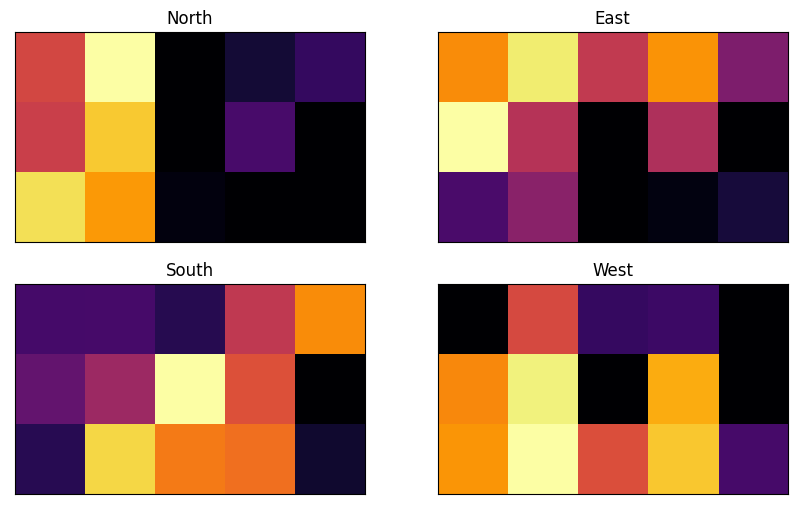

In [26]:
x=np.load(filepath+"xdata_soft.npy")
y=np.load(filepath+"ydata1_soft.npy")

#mean_values = np.mean(x, axis=1, keepdims=True)
#std_dev_values = np.std(x, axis=1, keepdims=True)
#x = (x - mean_values) / std_dev_values

n=np.zeros_like(x[0])
s=np.zeros_like(x[0])
w=np.zeros_like(x[0])
e=np.zeros_like(x[0])
for i in range(len(x)):
    if list(y[i])==[1,1,0,0]: 
        sig=x[i]
        #sig[sig!=np.max(sig)]=0
        n+=sig
    elif list(y[i])==[0,1,1,0]: 
        sig=x[i]
        #sig[sig!=np.max(sig)]=0
        e+=sig
    elif list(y[i])==[0,0,1,1]: 
        sig=x[i]
        #sig[sig!=np.max(sig)]=0
        s+=sig
    elif list(y[i])==[1,0,0,1]: 
        sig=x[i]
        #sig[sig!=np.max(sig)]=0
        w+=sig

fig, axs = plt.subplots(2, 2, figsize=(10, 6))

axs[0][0].imshow(n,cmap='inferno')
axs[0][0].set_title("North")
axs[0][0].xaxis.set_visible(False)
axs[0][0].yaxis.set_visible(False)

axs[0][1].imshow(e,cmap='inferno')
axs[0][1].set_title("East")
axs[0][1].xaxis.set_visible(False)
axs[0][1].yaxis.set_visible(False)

axs[1][0].imshow(s,cmap='inferno')
axs[1][0].set_title("South")
axs[1][0].xaxis.set_visible(False)
axs[1][0].yaxis.set_visible(False)

axs[1][1].imshow(w,cmap='inferno')
axs[1][1].set_title("West")
axs[1][1].xaxis.set_visible(False)
axs[1][1].yaxis.set_visible(False)

plt.show()

In [3]:


X,y=genDataSet(0,1,1,1,0) 
X=X[:,0:15]
print(X.shape)
Y_pred=ridge_model.predict(X)
assert len(Y_pred)==len(X),"Incorrect sizes"+str(len(Y_pred))+" "+str(len(X))
Y_pred[Y_pred<0.5]=0
Y_pred[Y_pred>=0.5]=1
Y_pred=Y_pred.reshape((len(Y_pred),2,2))
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

vid_not_started=True
pathtosave="savedEdge.avi"

for _,i in enumerate(range(0,len(X),1)): #len(x)
    ft1=get_foot_image(X[_])
    pred=Y_pred[_]
    axs[0].imshow(ft1.T,cmap='inferno')
    axs[0].set_title("Left foot")
    axs[0].xaxis.set_visible(False)
    axs[0].yaxis.set_visible(False)

    axs[1].imshow(pred.T,cmap="gist_gray")
    axs[1].set_title("Prediction")
    axs[1].xaxis.set_visible(False)
    axs[1].yaxis.set_visible(False)
    fig.tight_layout(pad=0.05)
    fig.savefig(path+"assets/"+"save"+".png")
    ad=cv2.imread(path+"assets/"+"save"+".png")
    if vid_not_started:
        h1, w1 = ad.shape[:2]
        out = cv2.VideoWriter(path+pathtosave,cv2.VideoWriter_fourcc(*'DIVX'), 15, (w1,h1))
        vid_not_started=False
    out.write(ad) #uncomment to record video
    if _%5000==0:
        print(_/len(X) *100,"%")
out.release()


X data: (4950, 30) /ny data: (4950, 3)
X data: (4950, 30) /ny data: (4950, 3)
X data: (4950, 30) /ny data: (4950, 3)
X data: (4950, 30) /ny data: (4950, 3)
X data: (4950, 30) /ny data: (4950, 3)
X data: (4950, 30) /ny data: (4950, 3)
X data: (4950, 30) /ny data: (4950, 3)
X data: (4950, 30) /ny data: (4950, 3)
X data: (4950, 30) /ny data: (4950, 3)
X data: (4950, 30) /ny data: (4950, 3)
(49500, 15)
1.1363636363636365 %
2.272727272727273 %
3.4090909090909087 %
4.545454545454546 %
5.681818181818182 %
6.8181818181818175 %
7.954545454545454 %
9.090909090909092 %
10.227272727272728 %
11.363636363636363 %
12.5 %
13.636363636363635 %
14.772727272727273 %
15.909090909090908 %
17.045454545454543 %
18.181818181818183 %
19.318181818181817 %
20.454545454545457 %
21.59090909090909 %
22.727272727272727 %
23.863636363636363 %
25.0 %
26.136363636363637 %
27.27272727272727 %
28.40909090909091 %
29.545454545454547 %
30.681818181818183 %
31.818181818181817 %
32.95454545454545 %
34.090909090909086 %
35.22

KeyboardInterrupt: 